<a href="https://colab.research.google.com/drive/1fvDBaa6-qc6ggwK37cQe7JZN1fqGhqjG#scrollTo=view-in-github" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network (DNN)



## 1. Load dataset

In [1]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_500.zip -d ./data500

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 53.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 162MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 198MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31M/

## 2. Import python libraries and define util functions

In [2]:
# Install library
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 51.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.functional.regression import mean_squared_error
from torchmetrics.functional.regression import mean_absolute_percentage_error
from torchsummary import summary

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for RMSE history after model training
def plot_rmse(rmse_train_history, rmse_valid_history, title=None):

    plt.plot(rmse_train_history)
    plt.plot(rmse_valid_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('RMSE')
    plt.xlabel('Epochs')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

# function to plot a line graph for MAPE history after model training
def plot_mape(mape_train_history, mape_valid_history, title=None):

    plt.plot(mape_train_history)
    plt.plot(mape_valid_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('MAPE')
    plt.xlabel('Epochs')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

# function to plot a line graph for loss history after model training
def plot_loss(loss_train_history, loss_valid_history, title=None):

    plt.plot(loss_train_history)
    plt.plot(loss_valid_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

# function to calculate the R2
def r_val(true,pred):  # R2 : Coefficient of determination

    true = pd.DataFrame(true)
    pred = pd.DataFrame(pred)
    result = true.corrwith(pred, method='pearson')
    return (np.round(result,4)[0])

In [4]:
set_seed(0)

## 3. Check dataset

In [6]:
path = './data500/26.831.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data


In [7]:
# image size = 56 x 56, 500 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data500/'

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
    X.append(img_read(src,file)/255.)  # normalize the image
    Y.append(float(file[:-4]))  # extract label from filename

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X.shape:',np.shape(X),'Y.shape:',np.shape(Y))

X.shape: (500, 56, 56) Y.shape: (500,)


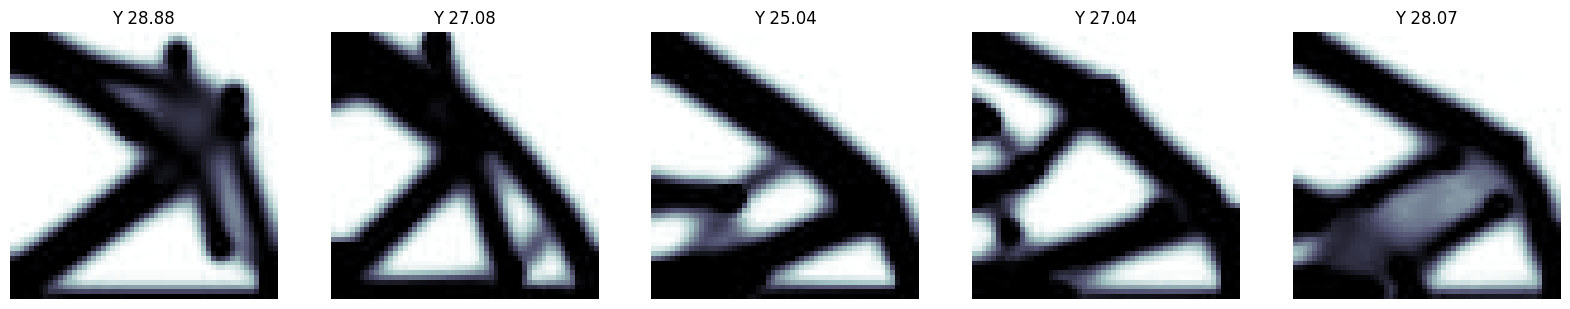

In [8]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X[i, :, :],cmap = plt.cm.bone)
    ax.set_title(f"Y {Y[i]:.2f}")
    ax.axis('off')
plt.show()

In [9]:
# split the data into 80% training set and 20% test set (test set can be considered as validation)
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)

# print the shapes and types of the training and test datasets
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

# adjust output scale to (0,1)
scaler = MinMaxScaler()
train_labels = scaler.fit_transform(train_labels.reshape(-1,1)).squeeze()

test_labels = scaler.transform(test_labels.reshape(-1,1))
# convert the numpy arrays to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)


# reshape the data for model training
train_images = train_images.reshape(400,-1,56,56).to(device)
test_images = test_images.reshape(100,-1,56,56).to(device)

# print the new sizes and types of the training and test datasets after reshaping
print(train_images.size(), test_images.size())
print(type(train_images), type(test_images))

# reshape the labels for training
train_labels = train_labels.reshape(400,-1).to(device)
test_labels = test_labels.reshape(100,-1).to(device)

# print the new sizes and types of the labels after reshaping
print(train_labels.size(), test_labels.size())
print(type(train_labels),  type(test_labels), test_labels.dtype)

(400, 56, 56) (100, 56, 56)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
torch.Size([400, 1, 56, 56]) torch.Size([100, 1, 56, 56])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([400, 1]) torch.Size([100, 1])
<class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32


## 5. Set to model architecture

In [11]:
# DNN Model
class DNN(nn.Module):
    def __init__(self,fcs_dim= [56*56,512,256,128,1], output_sigmoid = True):
        super(DNN, self).__init__()

        self.flatten = nn.Flatten()
        # define the fully connected layers
        self.fcs = nn.ModuleList()
        for fc_idx in range(len(fcs_dim)-2):
            self.fcs.append(nn.Linear(fcs_dim[fc_idx], fcs_dim[fc_idx+1]))
            self.fcs.append(nn.Dropout(0.2))
            self.fcs.append(nn.ReLU())

        self.fcs.append(nn.Linear(fcs_dim[len(fcs_dim)-2], fcs_dim[len(fcs_dim)-1]))
        if output_sigmoid:
            self.fcs.append(nn.Sigmoid())

    def forward(self, x):
        x = self.flatten(x)

        for fc in self.fcs:
            x = fc(x)

        return x


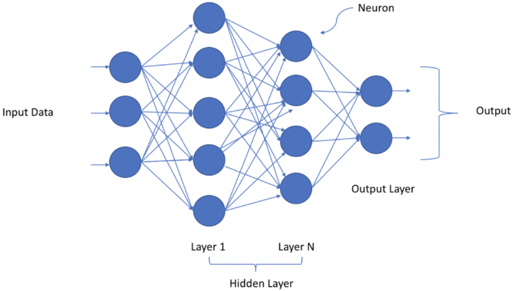

## 6. (Optional) Set model hyperparameters

In [12]:
# model architecture parameters

# Example usage:
# - fcs_dim: list of units for fully connected layers, where the last value determines the output size
# - output_sigmoid: set sigmoid function as a last activation function.
# When solving a problem that has MinMaxscaling in a regression problem, we typically use the sigmoid function as the last activation function.
# Because a range of output become 0-1.

# dafault settings; you can change these parameters if needed
model = DNN(fcs_dim= [56*56,1024,512,256,256,256,1], output_sigmoid = True).to(device)
# ------------------------------
# (**) Goal >> To increase # of total parameters (params) to improve its prediction accuracy!!
# ------------------------------
# Hyperparameter tuning example:
# - Increasing the number of layers and dimension of each linear layer (fcs_dim)
# - Set a last activation function as a sigmoid function(output_sigmoid)
# These changes might help the model learn more complex patterns, improving accuracy
# model =DNN(fcs_dim= [56*56,256,256,256,32,32,1], output_sigmoid = False).to(device)  # more deeper fully connected layers without last sigmoid function.
# ------------------------------

# print the model's summary for an overview of its structure
summary(model, (1, 56, 56))  # input shape: (channels, height, width)

model  # print model architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3136]               0
            Linear-2                 [-1, 1024]       3,212,288
           Dropout-3                 [-1, 1024]               0
              ReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
           Dropout-6                  [-1, 512]               0
              ReLU-7                  [-1, 512]               0
            Linear-8                  [-1, 256]         131,328
           Dropout-9                  [-1, 256]               0
             ReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 256]          65,792
          Dropout-12                  [-1, 256]               0
             ReLU-13                  [-1, 256]               0
           Linear-14                  [

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fcs): ModuleList(
    (0): Linear(in_features=3136, out_features=1024, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=1, bias=True)
    (16): Sigmoid()
  )
)

In [13]:
# training parameters

learning_rate = 0.001  # the rate at which the model learns; smaller values can lead to more precise learning, but too small may slow down training
batch_size = 32  # number of samples processed before updating the model; Increasing batch size can improve training speed, but requires more memory
num_epochs = 100  # number of times the entire training dataset is passed through the model; More epochs allow the model to learn better but may lead to overfitting

In [14]:
# create a DataLoader for the training dataset (includes shuffling)
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# define the loss function (MSE: Mean Squared Error)
criterion = nn.MSELoss()

# set the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# lists to track training and validation history
loss_train_history = []
rmse_train_history = []
mape_train_history = []

loss_valid_history = []
rmse_valid_history = []
mape_valid_history = []

for epoch in range(num_epochs):

    # training phase
    model.train()  # set the model to training mode
    total_loss = 0.0
    rmse_train = 0.0
    mape_train = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # reset the gradients
        outputs = model(images).to(device)
        labels = labels.to(device)
        loss = criterion(outputs, labels)  # calculate the loss
        loss.backward()  # backpropagate the loss
        optimizer.step()  # update the model parameters

        # accumulate metrics
        total_loss += loss.item()

        #inverse transformation for calculating metrics
        outputs = outputs.cpu().detach().numpy().reshape(1,-1)
        labels = labels.cpu().detach().numpy().reshape(1,-1)
        outputs = scaler.inverse_transform(outputs)
        labels = scaler.inverse_transform(labels)
        outputs = torch.from_numpy(outputs).clone().detach()#.reshape(1,-1)
        labels  = torch.from_numpy(labels).clone().detach()#.reshape(1,-1)
        rmse_train += mean_squared_error(outputs, labels, squared=False).item() # returns RMSE value if set to False
        mape_train += mean_absolute_percentage_error(outputs, labels).item() * 100
        if mean_absolute_percentage_error(outputs, labels).item() > 1000:
            break
    # calculate average metrics for the training set
    if mape_train > 1000:
        break
    average_loss_train = total_loss / len(train_loader)
    average_rmse_train = rmse_train / len(train_loader)
    average_mape_train = mape_train / len(train_loader)

    # save training metrics
    loss_train_history.append(average_loss_train)
    rmse_train_history.append(average_rmse_train)
    mape_train_history.append(average_mape_train)

    # evaluation phase (disable gradient calculation)
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_images).to(device)
        loss_val = criterion(test_outputs, test_labels).item()  # calculate the validation loss

        #inverse transformation for calculating metrics
        test_outputs_inv = test_outputs.cpu().detach().numpy().reshape(1,-1)
        test_labels_inv  = test_labels.cpu().detach().numpy().reshape(1,-1)
        test_outputs_inv = scaler.inverse_transform(test_outputs_inv)
        test_labels_inv  = scaler.inverse_transform(test_labels_inv)
        test_outputs_inv = torch.from_numpy(test_outputs_inv).clone().detach().reshape(1,-1)
        test_labels_inv  = torch.from_numpy(test_labels_inv).clone().detach().reshape(1,-1)

        rmse_val = mean_squared_error(test_outputs_inv, test_labels_inv, squared=False).item()  # RMSE for the validation set
        mape_val = mean_absolute_percentage_error(test_outputs_inv, test_labels_inv).item() * 100  # MAPE for the validation set

    # save training metrics
    loss_valid_history.append(loss_val)
    rmse_valid_history.append(rmse_val)
    mape_valid_history.append(mape_val)

    # print training and validation metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], TRAIN_RMSE: {average_rmse_train:.4f}, TRAIN_MAPE: {average_mape_train:.4f}, VAL_RMSE: {rmse_val:.4f}, VAL_MAPE: {mape_val:.4f}")

Epoch [1/100], TRAIN_RMSE: 1.4894, TRAIN_MAPE: 4.7575, VAL_RMSE: 1.6498, VAL_MAPE: 5.0151
Epoch [2/100], TRAIN_RMSE: 1.4365, TRAIN_MAPE: 4.5875, VAL_RMSE: 1.3410, VAL_MAPE: 4.0742
Epoch [3/100], TRAIN_RMSE: 1.1930, TRAIN_MAPE: 3.7629, VAL_RMSE: 1.0754, VAL_MAPE: 3.2884
Epoch [4/100], TRAIN_RMSE: 1.1548, TRAIN_MAPE: 3.5887, VAL_RMSE: 0.9573, VAL_MAPE: 2.8987
Epoch [5/100], TRAIN_RMSE: 0.9720, TRAIN_MAPE: 2.9292, VAL_RMSE: 1.0741, VAL_MAPE: 3.3351
Epoch [6/100], TRAIN_RMSE: 0.9198, TRAIN_MAPE: 2.8025, VAL_RMSE: 1.2147, VAL_MAPE: 3.5486
Epoch [7/100], TRAIN_RMSE: 0.9046, TRAIN_MAPE: 2.7503, VAL_RMSE: 0.8963, VAL_MAPE: 2.6060
Epoch [8/100], TRAIN_RMSE: 0.7694, TRAIN_MAPE: 2.3279, VAL_RMSE: 0.7790, VAL_MAPE: 2.3151
Epoch [9/100], TRAIN_RMSE: 0.7097, TRAIN_MAPE: 2.0833, VAL_RMSE: 0.8226, VAL_MAPE: 2.3613
Epoch [10/100], TRAIN_RMSE: 0.7236, TRAIN_MAPE: 2.1694, VAL_RMSE: 0.8412, VAL_MAPE: 2.3619
Epoch [11/100], TRAIN_RMSE: 0.7376, TRAIN_MAPE: 2.2474, VAL_RMSE: 0.8205, VAL_MAPE: 2.5877
Epoch [1

## 7. Visualize learning history

In [ ]:
# Graph Visualization
plot_loss(loss_train_history, loss_valid_history, '(a) Loss')  # Loss variation over epochs during training
plt.show()
plot_rmse(rmse_train_history, rmse_valid_history, '(b) RMSE')  # RMSE variation over epochs during training
plt.show()
plot_mape(mape_train_history, mape_valid_history, '(c) MAPE')  # MAPE variation over epochs during training
plt.show()

## 8. Evaluate model performance

 ----- evaluation results ----- 
 
valid RMSE :  0.0956
valid MAPE :  0.1833
valid R2 :  0.933


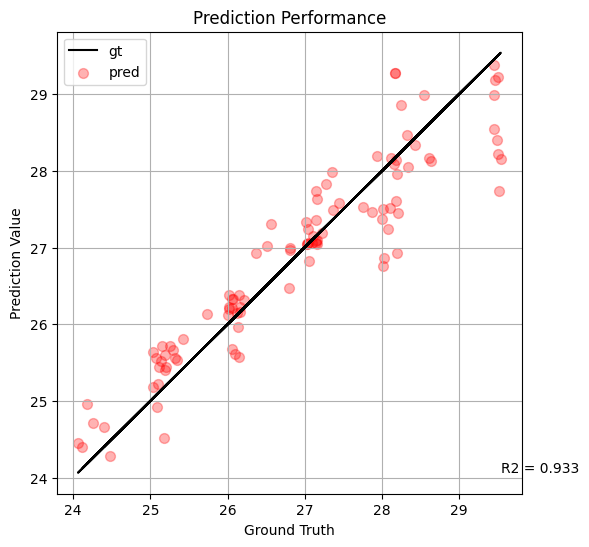

In [ ]:
# load the saved model and set it to evaluation mode
model.eval().to(device)

# predict using the model (on the validation dataset)
pred_labels = model(test_images)  # returns the predicted values (y_pred)

# evaluate the model performance (RMSE & MAPE)
each_rmse_test = mean_squared_error(pred_labels, test_labels, squared=False).item()
each_mape_test = mean_absolute_percentage_error(test_labels, pred_labels).item()

# calculate and visualize the R2
pred_labels = pred_labels.cpu().detach().numpy()
test_labels = test_labels.cpu().numpy()
pred_labels = scaler.inverse_transform(pred_labels)
test_labels = scaler.inverse_transform(test_labels)


plt.figure(figsize=(6,6))
plt.plot(test_labels, test_labels,'-',color='black')
plt.scatter(test_labels, pred_labels,s=50,alpha=0.3,color='red')
plt.legend(['gt','pred'],loc='upper left')
plt.title('Prediction Performance')
plt.text(test_labels.max(),test_labels.min(),'R2 = {}'.format(round(r_val(test_labels, pred_labels),4)))
plt.xlabel('Ground Truth')
plt.ylabel('Prediction Value')
plt.grid(True)


# fine-tune your model by minimizing rmse value (validation dataset)
print(" ----- evaluation results ----- ")
print(" ")
print("valid RMSE : " , np.round(each_rmse_test,4))
print("valid MAPE : " , np.round(each_mape_test,4))
print("valid R2 : " , r_val(test_labels, pred_labels))